In [1]:
using Random, LinearAlgebra, Distributions, ForwardDiff, Plots

In [17]:
function init_model_params()
    μ0 = 0
    Σ0 = 1
    A = 0.5
    Q = 1
    C = 1
    R = 1
    return μ0, Σ0, A, Q, C, R
end

function generate_data(model_params, T)
    μ0, Σ0, A, Q, C, R = model_params
    
    x_true = zeros(T)
    y_true = zeros(T)
    
    for t in 1:T
        if t > 1
            x_dist = Normal(A*x_true[t-1],Q)
        else
            x_dist = Normal(0,Q)
        end
        x_true[t] = rand(x_dist,1)[1]
        y_dist = Normal(C*x_true[t],R)
        y_true[t] = rand(y_dist,1)[1]
    end
    
    return x_true, y_true
end

function log_marginal_likelihood(model_params, T, y_true)
    μ0, Σ0, A, Q, C, R = model_params
    
    # Compute via Kalman filter
    log_likelihood = 0
    
    x_filt = 0
    P_filt = 0
    x_pred = μ0
    P_pred = Σ0
    
    for t in 1:T
        if t > 1
            # Predict
            x_pred = A * x_filt
            P_pred = A*P_filt*A' + Q
        end
        
        # Update
        yt = y_true[t] - C*x_pred
        S = C*P_pred*C' + R
        K = (S \ (C*P_pred))'
        x_filt = x_pred + K*yt
        P_filt = P_pred - K*C*P_pred
        
        log_likelihood += -0.5*(dot(yt,S\yt) + logdet(S) + log(2*π))
    end
    return log_likelihood
end


function log_normal(X,μ,Σ)
    log_norm = -0.5*log(2*π) - 0.5*log(Σ)
    diff = X - μ
    return log_norm .- 0.5 * diff.*(Σ\diff)
end

function log_target(X, X_anc, yt, model_params)
    μ0, Σ0, A, Q, C, R = model_params
    N = length(X)
    log_trans = log_normal(X,A*X_anc,Q)
    log_obs = log_normal(repeat([yt],N),C*X,R)
    return log_trans + log_obs
end

function log_prop(X, X_anc, λ)
    μ = λ .+ 0.5*X_anc
    return log_normal(X,μ,1)
end

function log_weights(X, X_anc, yt, λ, model_params)
    return log_target(X,X_anc,yt,model_params) - log_prop(X,X_anc,λ)
end

function sim_prop(X_anc, λ)
    N = size(X_anc)[1]
    μ = λ .+ 0.5*X_anc
    return μ + randn(N)
end

sim_prop (generic function with 1 method)

In [3]:
function gumbel_softmax_resampling(W,τ)
    N = size(W)[1]
    u = rand(N^2)
    g = -log.(-log.(u))
    inds = zeros(Int,N)
    for i in 1:N
        z = exp.((log.(W)+g[(1+N*(i-1)):(N+N*(i-1))])/τ)
        inds[i] = findmax(z)[2]
    end
    return inds
end

gumbel_softmax_resampling (generic function with 1 method)

In [18]:
function initialize_X(λ, N)
    X = λ .+ randn(N)
    return X
end

function resampling(W)
    # Stratified resampling
    N = size(W)[1]
    bins = cumsum(W,dims=1)
    ind = 0:N-1
    u = (ind + rand(N)) / N
    digitize = i -> searchsortedfirst(bins[:,1],i)
    return digitize.(u)
end

function vsmc_lower_bound(λ, model_params, N, y_true; τ=0.1, verbose=false)
    # Extract constants
    T = length(y_true)
    
    # Initialize SMC
    X = initialize_X(λ,N)
    X_anc = zeros(N)
    logW = log_weights(X,X_anc,y_true[1],λ,model_params)
    max_logW = max(logW...)
    W = exp.(logW .- max_logW)
    logZ = max_logW + log(sum(W)) - log(N)
    W /= sum(W)
    
    ESS = (1/sum(W.^2)) / N # Effective sample size
    
    for t in 2:T
        # Resampling
        ancestors = resampling(W) #gumbel_softmax_resampling(W,10) #resampling(W)
        X_anc = X[ancestors]
        
        # Propagation
        X = sim_prop(X_anc, λ)
        
        # Reweighting
        logW = log_weights(X,X_anc,y_true[t],λ,model_params)
        max_logW = max(logW...)
        W = exp.(logW .- max_logW)
        logZ += max_logW + log(sum(W)) - log(N)
        W /= sum(W)
        ESS = (1/sum(W.^2)) / N
    end
    if verbose
        println("ESS: ", ESS)
    end
    return logZ
end

function cv_log_cat(λ, model_params, N, y_true)
    # Extract constants
    T = length(y_true)
    
    # Initialize SMC
    X = initialize_X(λ,N)
    X_anc = zeros(N)
    logW = log_weights(X,X_anc,y_true[1],λ,model_params)
    max_logW = max(logW...)
    W = exp.(logW .- max_logW)
    W /= sum(W)
    log_cat = 0
    
    ESS = (1/sum(W.^2)) / N # Effective sample size
    
    for t in 2:T
        # Resampling
        ancestors = resampling(W) #gumbel_softmax_resampling(W,10) #resampling(W)
        log_cat += sum(log.(W[ancestors]))
        X_anc = X[ancestors]
        
        # Propagation
        X = sim_prop(X_anc, λ)
        
        # Reweighting
        logW = log_weights(X,X_anc,y_true[t],λ,model_params)
        max_logW = max(logW...)
        W = exp.(logW .- max_logW)
        W /= sum(W)
    end
    return log_cat
end

cv_log_cat (generic function with 1 method)

In [19]:
T = 2
N = 2

# Initialize model params
model_params = init_model_params()

# Generate data
x_true, y_true = generate_data(model_params, T)
println("x: ", x_true)
println("y: ", y_true)

# True log marginal likelihood via Kalman filter
log_marginal = log_marginal_likelihood(model_params, T, y_true)
println("True log-marginal likelihood: ", log_marginal)

# Initialize variational params
λ = randn(1)[1]
println("λ0: ", λ)

function objective(λ;τ=0.01)
    return vsmc_lower_bound(λ,model_params,N,y_true,τ=τ)
end

function rho(iter,∇L,ss;δ=1e-16,t=0.1,η=0.1)
    s = t*(∇L)^2+(1-t)*ss
    ρ = η*iter^(-1/2+δ)*(1+sqrt(s))^(-1)
    return s,ρ
end

x: [0.7047558645141173, 0.40631525328219104]
y: [2.5250044568129577, 1.5702364657557693]
True log-marginal likelihood: -4.362705726474768
λ0: -0.7543935468034308


rho (generic function with 1 method)

λ*: 0.554899433569748
ESS: 0.9620146051819043
Final VSMC bound: -3.9292413939812345


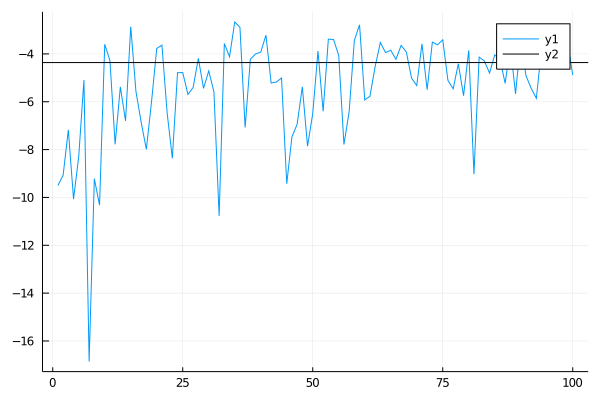

In [20]:
iters = 100
λs = zeros(iters)
λs[1] = λ
vsmcb = zeros(iters)
vsmcb[1] = vsmc_lower_bound(λ,model_params,N,y_true)
ss = ones(iters)
ρs = zeros(iters)
τs = range(1,0.01,length=iters)
for i in 1:iters-1
    ∇λ = ForwardDiff.gradient(λ->objective(λ[1]),[λs[i]])[1] #+ 
        #objective(λ,0)*ForwardDiff.gradient(λ->cv_log_cat(λ[1],model_params,N,y_true),[λ])[1]
        #ForwardDiff.gradient(λ->cv_log_cat(λ[1],model_params,N,y_true),[λs[i]])[1]
    s,ρ = rho(i,∇λ,ss[i])
    ss[i+1] = s
    ρs[i+1] = ρ
    λs[i+1] = λs[i] + ρ*∇λ
    vsmcb[i+1] = vsmc_lower_bound(λs[i+1],model_params,N,y_true)
end
println("λ*: ",λs[iters])
println("Final VSMC bound: ", vsmc_lower_bound(λs[iters],model_params,N,y_true,verbose=true))
plot(1:iters,vsmcb)
hline!([log_marginal],linecolor=:black)

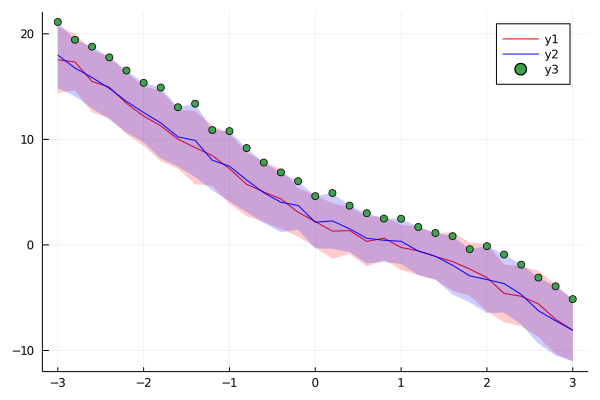

In [37]:
function estimate_var(λs;num_samples=100)
    means = zeros(length(λs))
    vars = zeros(length(λs))
    for i in 1:length(λs)
        λ = λs[i]
        ∇λ = zeros(num_samples)
        for j in 1:num_samples
            ∇λ[j] = ForwardDiff.gradient(λ->objective(λ[1]),[λ])[1]
        end
        means[i] = mean(∇λ)
        vars[i] = var(∇λ)
    end
    return means, vars
end

function estimate_var_cv(λs;num_samples=100)
    means = zeros(length(λs))
    vars = zeros(length(λs))
    for i in 1:length(λs)
        λ = λs[i]
        ∇λ = zeros(num_samples)
        for j in 1:num_samples
            ∇λ[j] = ForwardDiff.gradient(λ->objective(λ[1]),[λ])[1] #+ #ForwardDiff.gradient(λ->objective(λ[1],0.01),[λ])[1]-
                #objective(λ)*ForwardDiff.gradient(λ->cv_log_cat(λ[1],model_params,N,y_true),[λ])[1]
                - ForwardDiff.gradient(λ->cv_log_cat(λ[1],model_params,N,y_true),[λ])[1]
        end
        means[i] = mean(∇λ)
        vars[i] = var(∇λ)
    end
    return means, vars
end

xs = -3:0.2:3
means, vars = estimate_var(xs)
stds = sqrt.(vars)
cvmeans, cvvars = estimate_var_cv(xs)
cvstds = sqrt.(vars)
plot(xs, means, ribbon=stds, linecolor="red", fillcolor="red", fillalpha=0.2)
plot!(xs, cvmeans, ribbon=cvstds, linecolor="blue", fillcolor="blue", fillalpha=0.2)

In [8]:
function estimate_τ_var(λ, τs;num_samples=100)
    means = zeros(length(τs))
    vars = zeros(length(τs))
    for i in 1:length(τs)
        τ = τs[i]
        ∇λ = zeros(num_samples)
        for j in 1:num_samples
            ∇λ[j] = ForwardDiff.gradient(λ->objective(λ[1],τ),[λ])[1]
        end
        means[i] = mean(∇λ)
        vars[i] = var(∇λ)
    end
    return means, vars
end

xs = 10:-0.1:0.01
means, vars = estimate_τ_var(1,xs)
stds = sqrt.(vars)
plot(xs, means, ribbon=(stds,stds), linecolor="red", fillcolor="red", fillalpha=0.2)
#plot!(means, , fillcolor="red", fillalpha=0.3)

LoadError: [91mMethodError: no method matching objective(::ForwardDiff.Dual{ForwardDiff.Tag{var"#15#16"{Float64},Int64},Int64,1}, ::Float64)[39m
[91m[0mClosest candidates are:[39m
[91m[0m  objective(::Any; τ) at In[5]:20[39m

In [9]:
function init_model_params()
    μ0 = 0
    Σ0 = 1
    obs_mean = x -> x^2/2
    obs_var = x -> exp(x/2)
    return μ0, Σ0, obs_mean, obs_var
end

function generate_data(model_params, T)
    μ0, Σ0, obs_mean, obs_var = model_params
    
    x_true = zeros(T)
    y_true = zeros(T)
    
    for t in 1:T
        x_true[t] = μ0 + sqrt(Σ0)*randn(1)[1]
        y_true[t] = obs_mean(x_true[t]) + sqrt(obs_var(x_true[t]))*x_true[t]
    end
    
    return x_true, y_true
end

function init_prop_params()
    μ = randn(1)[1]
    logσ2 = randn(1)[1]
    return μ, logσ2
end

function log_marginal_likelihood(model_params, T, y_true)
    μ0, Σ0, A, Q, C, R = model_params
    
    # Compute via Kalman filter
    log_likelihood = 0
    
    x_filt = 0
    P_filt = 0
    x_pred = μ0
    P_pred = Σ0
    
    for t in 1:T
        if t > 1
            # Predict
            x_pred = A * x_filt
            P_pred = A*P_filt*A' + Q
        end
        
        # Update
        yt = y_true[t] - C*x_pred
        S = C*P_pred*C' + R
        K = (S \ (C*P_pred))'
        x_filt = x_pred + K*yt
        P_filt = P_pred - K*C*P_pred
        
        log_likelihood += -0.5*(dot(yt,S\yt) + logdet(S) + log(2*π))
    end
    return log_likelihood
end


function log_normal(X,μ,Σ)
    diff = X - μ
    log_norm = -0.5 * diff.^2 .* (1 ./ Σ)
    if length(Σ) > 1
        log_norm = log_norm .- 0.5*log(2*π) - 0.5*log.(Σ)
    else
        log_norm = log_norm .- 0.5*log(2*π) .- 0.5*log(Σ)
    end
    return log_norm
end

function log_target(X, X_anc, yt, model_params)
    μ0, Σ0, obs_mean, obs_var = model_params
    N = length(X)
    log_trans = log_normal(X,repeat([μ0],N),Σ0)
    log_obs = log_normal(repeat([yt],N),obs_mean.(X),obs_var.(X))
    return log_trans + log_obs
end

function log_prop(X, X_anc, prop_params)
    μ, logσ2 = prop_params
    N = length(X)
    return log_normal(X,repeat([μ],N),exp(logσ2))
end

function log_weights(X, X_anc, yt, prop_params, model_params)
    return log_target(X,X_anc,yt,model_params) - log_prop(X,X_anc,prop_params)
end

function initialize_X(prop_params, N)
    μ, logσ2 = prop_params
    X = μ .+ sqrt(exp(logσ2)) .* randn(N)
    return X
end

function vsmc_lower_bound(prop_params, model_params, N, y_true; verbose=false)
    # Initialize SMC
    X = initialize_X(prop_params,N)
    X_anc = zeros(N)
    logW = log_weights(X,X_anc,y_true[1],prop_params,model_params)
    max_logW = max(logW...)
    W = exp.(logW .- max_logW)
    logZ = max_logW + log(sum(W)) - log(N)
    W /= sum(W)
    
    ESS = (1/sum(W.^2)) / N # Effective sample size
    
    if verbose
        println("ESS: ", ESS)
    end
    return logZ, W, X
end

vsmc_lower_bound (generic function with 1 method)

x: [2.0155036459903806]
y: [1]
μ: 0.3081282713666144
σ2: 2.7230003970532697
μ*: 0.19902548588509836
σ2*: 2.8296095526367364
ESS: 0.8404918869473106
Final VSMC bound: -1.0757073557017185


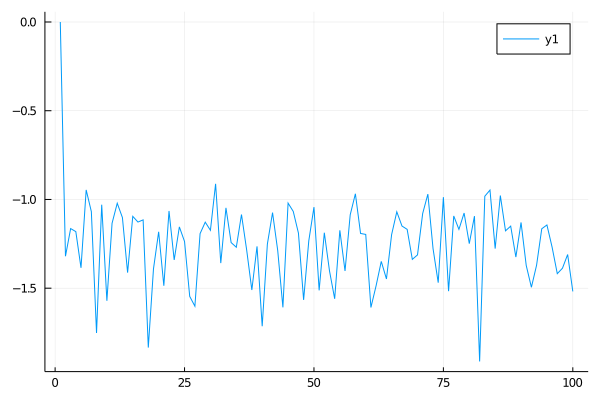

In [10]:
T = 1
N = 10

# Initialize model params
model_params = init_model_params()

# Generate data
x_true, y_true = generate_data(model_params, T)
y_true = [1]
println("x: ", x_true)
println("y: ", y_true)

# True log marginal likelihood via Kalman filter
#log_marginal = log_marginal_likelihood(model_params, T, y_true)
#println("True log-marginal likelihood: ", log_marginal)

# Initialize variational params
μ, logσ2 = init_prop_params()
println("μ: ", μ)
println("σ2: ", exp(logσ2))

function objective(prop_params)
    logZ, W, X = vsmc_lower_bound(prop_params,model_params,N,y_true)
    return logZ
end

function adam(iter,∇L,ss;δ=1e-16,t=0.1,η=0.1)
    s = t*(∇L)^2+(1-t)*ss
    ρ = η*iter^(-1/2+δ)*(1+sqrt(s))^(-1)
    return s,ρ
end

function sqrtstep(iter)
    return 0,1e-1/sqrt(iter)
end

iters = 100
μs = zeros(iters)
logσ2s = zeros(iters)
μs[1] = μ
logσ2s[1] = logσ2
vsmcb = zeros(iters)
ss = ones(iters,2)
ρs = zeros(iters,2)

for i in 1:iters-1
    ∇p = ForwardDiff.gradient(p->objective(p),[μ,logσ2])
    sμ,ρμ = adam(i,∇p[1],ss[i,1])
    ss[i+1,1] = sμ
    ρs[i+1,1] = ρμ
    sσ,ρσ = adam(i,∇p[2],ss[i,2])
    ss[i+1,2] = sσ
    ρs[i+1,2] = ρσ
    μs[i+1] = μs[i] + ρμ*∇p[1]
    logσ2s[i+1] = logσ2s[i] + ρσ*∇p[2]
    vsmcb[i+1] = vsmc_lower_bound((μs[i+1],logσ2s[i+1]),model_params,N,y_true)[1]
end
println("μ*: ",μs[iters])
println("σ2*: ",exp(logσ2s[iters]))
logZ, W, X = vsmc_lower_bound((μs[iters],logσ2s[iters]),model_params,N,y_true,verbose=true)
println("Final VSMC bound: ", logZ)
plot(1:iters,vsmcb)

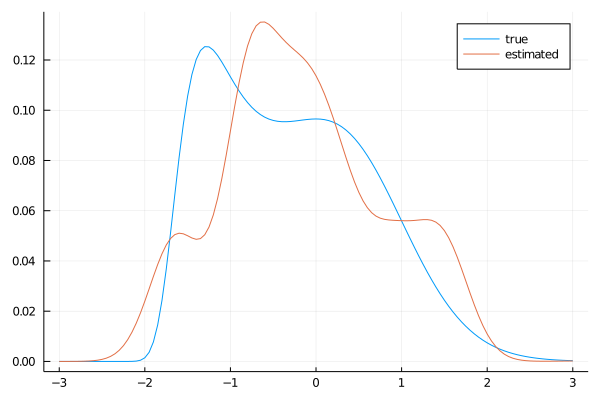

In [11]:
function target_cond_density(x,y)
    d = zeros(length(x))
    x_dist = Normal()
    for i in 1:length(x)
        y_dist = Normal(x[i]^2/2,exp(x[i]/2))
        d[i] = exp(logpdf(x_dist,x[i]) + logpdf(y_dist,y))
    end
    return d
end
x = -3:0.05:3
post_den = target_cond_density(x,y_true[1])
plot(x,post_den,label="true")

function variational_kernel_density(x,X,W;h=0.3)
    d = zeros(length(x))
    N = length(X)
    ϕ = Normal()
    for i in 1:length(x)
        for j in 1:N
            d[i] += W[j]*pdf(ϕ,(x[i]-X[j])/h)
        end
    end
    return d
end

var_den = variational_kernel_density(x,X,W)
plot!(x,var_den,label="estimated")

#ii = sortperm(X)
#plot!(X[ii],W[ii],label="estimated")